<a href="https://colab.research.google.com/github/miguelpereira25/CNN-internship-/blob/main/retrain_inception(teste_5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Thu Nov 11 10:33:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!pip install tensorflow===2.3.0

     |████████████████████████████████| 320.4 MB 49 kB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
     |████████████████████████████████| 2.9 MB 38.7 MB/s 
     |████████████████████████████████| 459 kB 48.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [30]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/dataset/train'
valid_path = '/content/drive/MyDrive/dataset/test'

In [58]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [59]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [60]:
folders = glob('/content/drive/MyDrive/dataset/train/*')

In [61]:
x = Flatten()(inception.output)

In [62]:
x = Dense(512, activation='relu')(x)

x = BatchNormalization()(x)
x = Dropout(0.3)(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [63]:
# view the structure of the model
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_96[0][0]     
_______________________________________________________________________________________

In [64]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [65]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [66]:

# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 76 images belonging to 4 classes.


In [67]:

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 41 images belonging to 4 classes.


In [68]:
import matplotlib.pyplot as plt

import datetime

In [40]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig(f'results__'+str(datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))+'.png')

In [69]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/50
3/3 [==============================] - 5s 2s/step - loss: 2.4309 - accuracy: 0.3947 - val_loss: 4.7102 - val_accuracy: 0.6585
Epoch 2/50
3/3 [==============================] - 2s 764ms/step - loss: 0.5040 - accuracy: 0.8026 - val_loss: 5.1891 - val_accuracy: 0.6341
Epoch 3/50
3/3 [==============================] - 3s 1s/step - loss: 0.2068 - accuracy: 0.9211 - val_loss: 4.8979 - val_accuracy: 0.6341
Epoch 4/50
3/3 [==============================] - 3s 957ms/step - loss: 0.2370 - accuracy: 0.9342 - val_loss: 3.9185 - val_accuracy: 0.6585
Epoch 5/50
3/3 [==============================] - 2s 763ms/step - loss: 0.1038 - accuracy: 0.9868 - val_loss: 3.4882 - val_accuracy: 0.6829
Epoch 6/50
3/3 [==============================] - 2s 827ms/step - loss: 0.0791 - accuracy: 0.9868 - val_loss: 3.2142 - val_accuracy: 0.6829
Epoch 7/50
3/3 [==============================] - 2s 789ms/step - loss: 0.0503 - accuracy: 0.9868 - val_loss: 3.2211 - val_accuracy: 0.6585
Epoch 8/50
3/3 [==========

In [4]:
import tensorflow as tf
tf.__version__

'2.7.0'

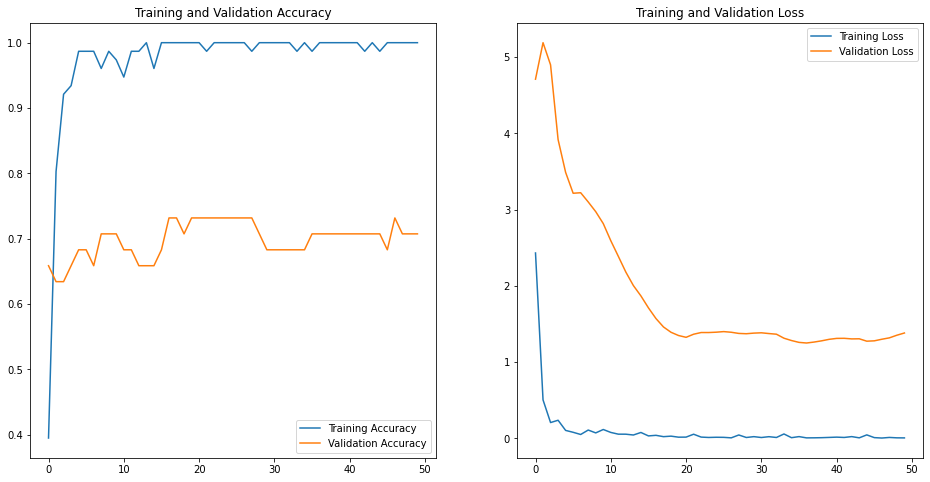

In [70]:
plot_results(r)